# Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization,\
 DepthwiseConv2D, LayerNormalization
from keras.layers import BatchNormalization, LayerNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
import time
import matplotlib as mpl
import sys

!pip install mat73
import mat73
!pip install tensorflow_addons
import tensorflow_addons as tfa


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

topic = 'Ming/Public_Data'
work_dir = '/content/gdrive/My Drive/Colab Notebooks/' + topic
import os
os.chdir(work_dir)
!pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Ming/Public_Data


In [27]:
################### Data mat ####################
'''
Experiment 1: Gaussian_steady_state_512.mat
Experiment 2: Exponential_transient_256.mat
Experiment 3: Gaussian_steady_state_3D.mat
Experiment 4: Channel_Binary_steady_state_128.mat
Experiment 5: Channel_Continuous_steady_state_128.mat
'''
experiment = 4 # 5
if experiment == 4:
  cov_type = 'Channel_Binary'
  Dname = 'DCGAN_discriminator_discontinuous'
  Gname = 'DCGAN_generator_discontinuous'
elif experiment == 5:
  cov_type = 'Channel_Continuous'
  Dname = 'DCGAN_discriminator_continuous'
  Gname = 'DCGAN_generator_continuous'

pump_type = 'steady_state'
ext = '128.mat'
data = mat73.loadmat('./Data/'+'_'.join([cov_type,pump_type,ext]))


In [28]:
pump_well_id = data['pump_well_id'].astype(int)-1

y_save = data['y_save_monitored']

fields = data['fields'].T

alpha = data['rv'].T

Y_raw = y_save
Y = np.zeros(y_save.shape)
Y = np.delete(Y,0,axis=1)

for ii in range(Y.shape[-1]):
  Y[:,:,ii] = np.delete(Y_raw[:,:,ii],pump_well_id[ii],axis=1)

NR = Y.shape[0]
Y = Y.reshape([NR,-1])


In [14]:
# add noise to data
Y_noised = np.zeros_like(Y)
for i in range(Y.shape[0]):
  Y_noised[i]  = Y[i] + np.random.normal(0,np.abs(Y[i]*0.05),[1,Y[i].shape[0]])

# split data to train and test set
train_test_cut = int(0.9*alpha.shape[0])
X_train, X_test = alpha[:train_test_cut], alpha[train_test_cut:]
Y_train, Y_test = Y_noised[:train_test_cut], Y_noised[train_test_cut:]

## Define DC-GAN container class

In [7]:
class ConvGAN():
  def __init__(self):
    self.img_rows = 128
    self.img_cols = 128
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 16
    print(self.img_shape)
    optimizer = Adam(1e-4, 0.5)

    self.discriminator = None
    self.generator = None


In [29]:
'''
Experiment 4: DCGAN_discriminator_discontinuous & DCGAN_generator_discontinuous
Experiment 5: DCGAN_discriminator_continuous & DCGAN_generator_continuous
'''
conv_gan = ConvGAN()
conv_gan.discriminator = tf.keras.models.load_model('./Saved_Model/'+Dname)
conv_gan.generator = tf.keras.models.load_model('./Saved_Model/'+Gname)


(128, 128, 1)


## DC-GAN Decoding & Smoothing


In [30]:
############### define domain with (0,0) at center ######
Lox, Loy = 1, 1
nx, ny = 128, 128
dx, dy = Lox/nx, Loy/ny
x = np.arange((-Lox/2+dx/2),(Lox/2),dx)
y = np.arange((-Lox/2+dx/2),(Lox/2),dy)
# Domain bounds   
lbs = np.array([min(x),min(y)])
ubs = np.array([max(x),max(y)])

Xm, Ym = np.meshgrid(x,y)

## Smoothing Kernels

In [31]:
in_channels = 1  # the number of input channels
kernel_size = 3  # set the filter size of Gaussian filter
test_x = tf.random.normal([1,9,9,1])

h_kernel = np.array([[0, 0, 0],[2/9, 5/9, 2/9],[0, 0, 0]]) # compute the weights of the filter with the given size (and additional params)
h_kernel = np.expand_dims(h_kernel, axis=-1)
h_kernel = np.repeat(h_kernel, in_channels, axis=-1) # apply the same filter on all the input channels
h_kernel= np.expand_dims(h_kernel, axis=-1)  # for shape compatibility reasons
h_layer = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
test_x = h_layer(test_x)
h_layer.set_weights([h_kernel])
h_layer.trainable = False  # the weights should not change during training

v_kernel = np.array([[0, 2/9, 0],[0, 5/9, 0],[0, 2/9, 0]]) # compute the weights of the filter with the given size (and additional params)
v_kernel = np.expand_dims(v_kernel, axis=-1)
v_kernel = np.repeat(v_kernel, in_channels, axis=-1) # apply the same filter on all the input channels
v_kernel= np.expand_dims(v_kernel, axis=-1)  # for shape compatibility reasons
v_layer = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
test_x = v_layer(test_x)
v_layer.set_weights([v_kernel])
v_layer.trainable = False  # the weights should not change during training


Text(0.5, 1.0, 'Generated from GAN')

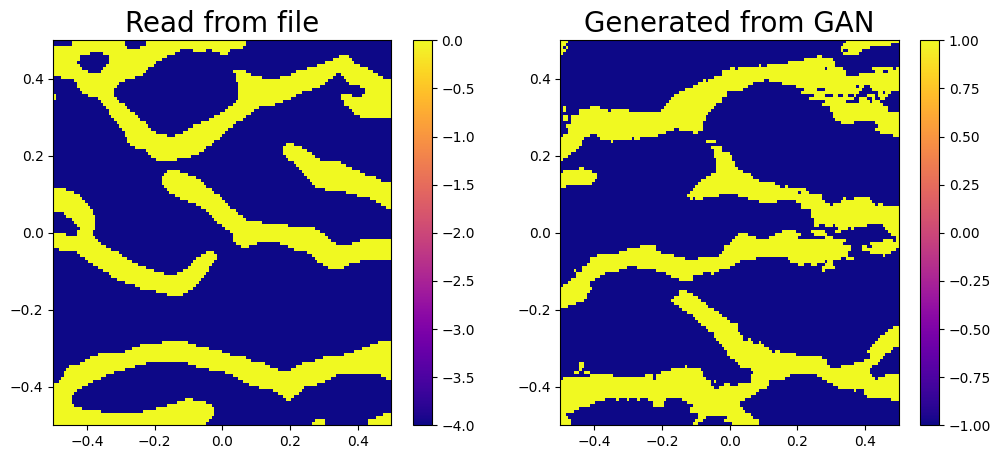

In [34]:
fid = 10

gen_imgs = conv_gan.generator.predict(X_test,verbose=0)

true_imgs = gen_imgs
if cov_type == 'Channel_Continuous':
  for i in range(3):
    true_imgs = h_layer(true_imgs)
    true_imgs = v_layer(true_imgs)
  true_imgs = true_imgs.numpy()
elif cov_type == 'Channel_Binary':
    true_imgs[true_imgs>0] = 1.0
    true_imgs[true_imgs<0] = -1.0
true_imgs  = true_imgs[:,:,:,0]

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,np.reshape(fields[fid+train_test_cut], (nx,ny), order='F'), cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_title('Read from file',fontsize=20)

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,true_imgs[fid,:,:], cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_title('Generated from GAN',fontsize=20)


# Define NN

In [21]:
hidden_act = None
hidden_dim = 3000
input = Input(shape = (Y_train.shape[-1],))
g = BatchNormalization()(input)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g_out = Dense(16)(g)
g_out = LayerNormalization(axis=1)(g_out)

G = Model(input, g_out, name = 'experiment_name')
G.summary()


alpha_loss_weight = np.ones((16,))

alpha_loss_weight /= np.linalg.norm(alpha_loss_weight)

def weighted_mse(weights=alpha_loss_weight):
  def loss(y_true, y_pred):
    squared_difference_1 = tf.square(y_true - y_pred)*weights
    total_loss = tf.reduce_mean(squared_difference_1, axis=-1)
    return total_loss
  return loss


step = tf.Variable(0, trainable=False)
boundaries = [10000, 20000]
values = [1e-3, 1e-4, 1e-5]
learning_rate_fn = PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)
G.compile(loss=weighted_mse(), optimizer=Adam(learning_rate, beta_1=0.5))

Model: "experiment_name"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600)]             0         
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3000)              1803000   
                                                                 
 batch_normalization_1 (Batc  (None, 3000)             12000     
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3000)              0         
                                                                 
 dense_1 (Dense)             (None, 3000)          

## Train Model

In [21]:
batch_size = 1000

epochs = 50000
print_interval = 1000
for epoch in range(epochs):
  idx = np.random.randint(0, Y_train.shape[0], batch_size)
  to_train = Y_train[idx]
  expect_output = X_train[idx]
  loss = G.train_on_batch(to_train, expect_output)
  if epoch % print_interval == 0:
      print("[epoch %d], [the loss is %f]" % (epoch, loss))

  if loss < 0.0001:
      break

[epoch 0], [the loss is 0.509389]


KeyboardInterrupt: ignored

# Inverse Estimations

In [35]:
predictions = G.predict(Y_test)

pred_imgs = conv_gan.generator.predict(predictions,verbose=0)

if cov_type == 'Channel_Continuous':
  for i in range(3):
    pred_imgs = h_layer(pred_imgs)
    pred_imgs = v_layer(pred_imgs)
  pred_imgs = pred_imgs.numpy
elif cov_type == 'Channel_Binary':
    pred_imgs[pred_imgs>0] = 1.0
    pred_imgs[pred_imgs<0] = -1.0

pred_imgs  = pred_imgs[:,:,:,0]

16/16 [==============================] - 0s 2ms/step


## Stats of validation data

In [24]:
acc_list = np.zeros((1,Y_test.shape[0]))
thres = 0.15

err_list = np.zeros((1,Y_test.shape[0]))
for check_id in range(Y_test.shape[0]):

  logK_pred = pred_imgs[check_id,:].reshape((nx,ny), order='F')
  logK_true = true_imgs[check_id,:].reshape((nx,ny), order='F')
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[0,check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))



Min Acc:  0.3275146484375
Max Acc:  0.72979736328125
Arg Max Acc:  312
Over 90%:  0
mean Acc:  0.47227587890625
std Acc:  0.06658920414435572


## Best Estimate

<ipython-input-36-dd0868c0356b>:18: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.1,


0.608154296875


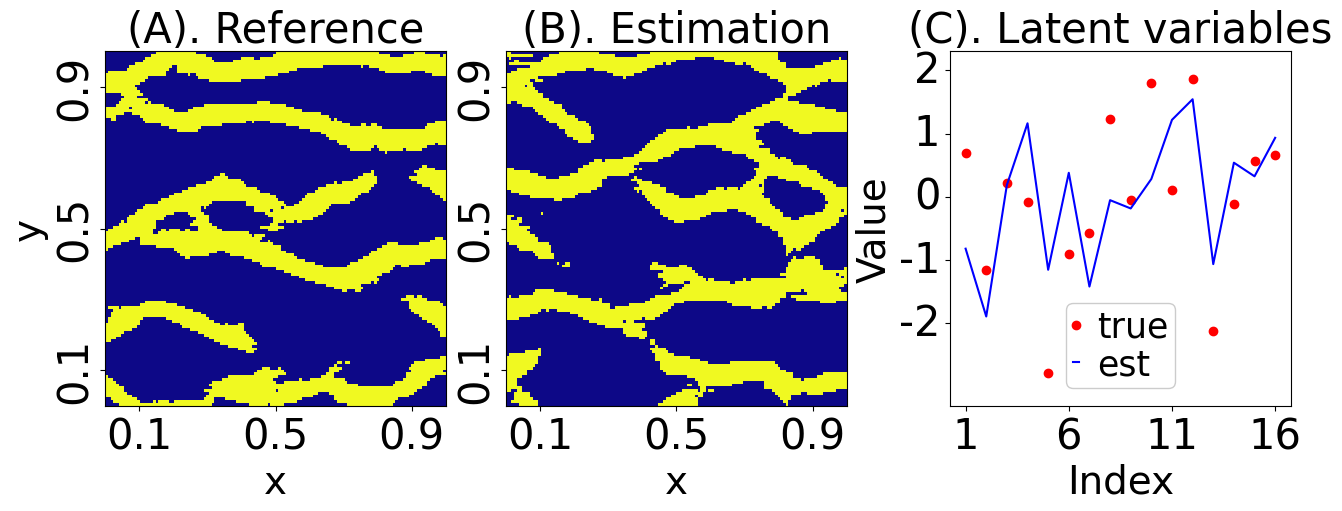

In [36]:
# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)

#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

logK_true = true_imgs[fid,:]
logK_pred = pred_imgs[fid,:]

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,3,figsize=(13,5), gridspec_kw={'width_ratios': [1, 1, 1]},constrained_layout = True)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
im.set_clim((minlK, maxlK))
ax.set_title('(A). Reference',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='plasma')

ax.set_title('(B). Estimation',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[2]
xplot = np.arange(1, predictions.shape[1]+1)
ax.plot(xplot, X_test[fid,:],'or',label='true')
ax.plot(xplot, predictions[fid,:],'b',label='est')


xticks = np.arange(1, predictions.shape[1]+1,5)
xlabels = np.arange(1, predictions.shape[1]+1,5)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=axis_tick_font_size,ha='center')

yticks = np.arange(-2, 3)
ylabels = np.arange(-2, 3)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,fontsize=axis_tick_font_size, ha='right', va='center')

ax.set_ylim([np.floor(min(np.hstack((X_test[fid,:],predictions[fid,:]))))-0.3,
             np.ceil(max(np.hstack((X_test[fid,:],predictions[fid,:]))))+0.3])

ax.set_xlabel('Index',fontsize=axis_label_font_size)
ax.set_ylabel('Value',fontsize=axis_label_font_size)

ax.legend(loc='lower center',ncol=1,prop={'size': legend_fontszie}, framealpha=1, \
          facecolor='none',borderpad=0.2,labelspacing=0.1,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

ax.set_title('(C). Latent variables',fontsize=title_size)

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))
